In [ ]:
from model import common
import torch
import numpy as np
import yaml
import os
import copy
import matplotlib.pyplot as plt

In [2]:
with open(os.path.join("test.yaml"), "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

dncnn = []
from model.dncnn import make_model
config["model"]["name"], config["model"]["level"] = "DnCNN", "S"

for backbone, n_corr, n_ch, path in [
    ("conv", False, 0, "dncnn-lite/model_naive.pt"),
    ("conv", False, 10, "dncnn-lite/model_nadd.pt"),
    ("conv", True, 10, "dncnn-lite/model_corr.pt"),
    ("ours", True, 10, "dncnn-lite/model_ours.pt")
]:
    config["model"]["backbone"] = backbone
    config["N_augment"]["N_corr"], config["N_augment"]["N_ch"] = n_corr, n_ch
    model = make_model(copy.deepcopy(config)).cuda()
    model.load_state_dict(torch.load(path), strict=True)
    dncnn.append(model)

unet = []
from model.unet import make_model
config["model"]["name"], config["model"]["level"] = "UNet", "S"

for backbone, n_corr, n_ch, path in [
    ("conv", False, 0, "unet-lite/model_naive.pt"),
    ("conv", False, 10, "unet-lite/model_nadd.pt"),
    ("conv", True, 10, "unet-lite/model_corr.pt"),
    ("ours", True, 10, "unet-lite/model_ours.pt")
]:
    config["model"]["backbone"] = backbone
    config["N_augment"]["N_corr"], config["N_augment"]["N_ch"] = n_corr, n_ch
    model = make_model(copy.deepcopy(config)).cuda()
    model.load_state_dict(torch.load(path), strict=True)
    unet.append(model)

model loaded!: DNCNN-S+conv
model loaded!: DNCNN-S+conv
model loaded!: DNCNN-S+conv
model loaded!: DNCNN-S+ours
model loaded!: UNet-S+conv
model loaded!: UNet-S+conv
model loaded!: UNet-S+conv
model loaded!: UNet-S+ours


In [3]:
sino_clean = torch.from_numpy(np.load("sino_clean.npy")).unsqueeze(0).unsqueeze(0).cuda()
sino_noisy = torch.from_numpy(np.load("sino_noisy_10.npy")).unsqueeze(0).unsqueeze(0).cuda()
metadata = torch.from_numpy(np.load("metadata.npy"))
reconstruction = common.NoiseRecon(config)

In [15]:
ldct, noise, clean = reconstruction(sino_clean, metadata, sino_noisy, N_ch=10)

results_dncnn = []
results_unet = []

input = (ldct + 500) / 500
noise = noise / 100
for i, model in enumerate(dncnn):
    model.eval()
    with torch.no_grad():
        output = model(input.clone(), noise = noise.clone() if i != 0 else None)
        output = (output * 500 - 500).clamp(-1024, 3072)
        results_dncnn.append(output)

for i, model in enumerate(unet):
    model.eval()
    with torch.no_grad():
        output = model(input.clone(), noise = noise.clone() if i != 0 else None)
        output = (output * 500 - 500).clamp(-1024, 3072)
        results_unet.append(output)

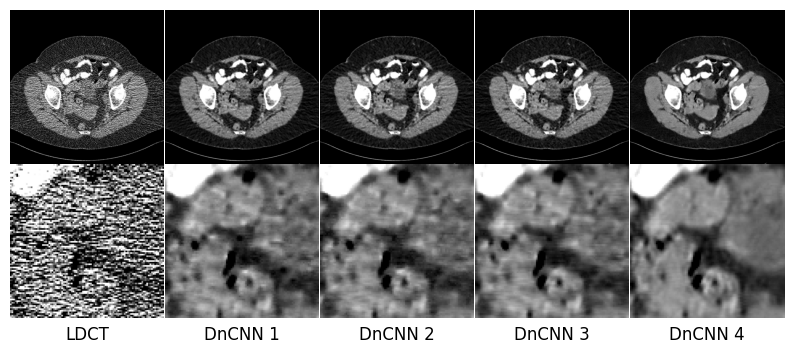

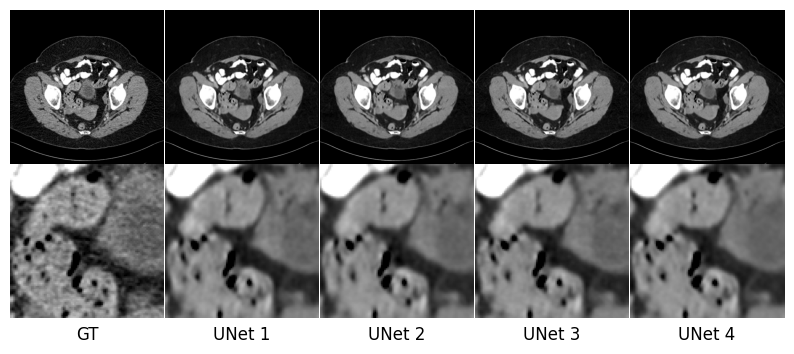

In [ ]:
x_idx, y_idx, roi_size = 175, 230, 96 

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs[0, 0].imshow(ldct[0, 0].cpu(), cmap='gray', vmin=-135, vmax=215)
axs[1, 0].imshow(ldct[0, 0, y_idx:y_idx+roi_size, x_idx:x_idx+roi_size].cpu(), cmap='gray', vmin=-135, vmax=215)
axs[1, 0].set_title("LDCT", y=-0.2, fontsize=12)

for i, output in enumerate(results_dncnn):
    axs[0, i+1].imshow(output[0, 0].cpu(), cmap='gray', vmin=-135, vmax=215)
    axs[1, i+1].imshow(output[0, 0, y_idx:y_idx+roi_size, x_idx:x_idx+roi_size].cpu(), cmap='gray', vmin=-135, vmax=215)
    axs[1, i+1].set_title(f"DnCNN {i+1}", y=-0.2, fontsize=12)

for ax in axs.ravel():
    ax.axis("off")
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs[0, 0].imshow(clean[0, 0].cpu(), cmap='gray', vmin=-135, vmax=215)
axs[1, 0].imshow(clean[0, 0, y_idx:y_idx+roi_size, x_idx:x_idx+roi_size].cpu(), cmap='gray', vmin=-135, vmax=215)
axs[1, 0].set_title("GT", y=-0.2, fontsize=12)

for i, output in enumerate(results_unet):
    axs[0, i+1].imshow(output[0, 0].cpu(), cmap='gray', vmin=-135, vmax=215)
    axs[1, i+1].imshow(output[0, 0, y_idx:y_idx+roi_size, x_idx:x_idx+roi_size].cpu(), cmap='gray', vmin=-135, vmax=215)
    axs[1, i+1].set_title(f"UNet {i+1}", y=-0.2, fontsize=12)

for ax in axs.ravel():
    ax.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()